## Lab 2

### Part 3. Poetry generation

Let's try to generate some poetry using RNNs. 

You have several choices here: 

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


In [71]:
import string
import os

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from IPython.display import clear_output
import matplotlib.pyplot as plt

In [72]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

### Data loading: Shakespeare

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`). Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [73]:
if not os.path.exists('sonnets.txt'):
    !wget https://raw.githubusercontent.com/girafe-ai/ml-mipt/master/homeworks_basic/Lab2_DL/sonnets.txt

with open('sonnets.txt', 'r') as iofile:
    text = iofile.readlines()
    
TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START : TEXT_END]
assert len(text) == 2616

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [74]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here

text = [phrase.lower() for phrase in text]
text = ''.join(text).lower()

assert len(text) == 100225, 'Are you sure you have concatenated all the strings?'
assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'
print('OK!')

OK!


### Data loading: "Евгений Онегин"


In [75]:
!wget https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt
    
with open('onegin.txt', 'r') as iofile:
    text_onegin = iofile.readlines()
    
text_onegin = [x.replace('\t\t', '') for x in text_onegin]

--2020-12-15 18:05:38--  https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 262521 (256K) [text/plain]
Saving to: ‘onegin.txt.3’

onegin.txt.3        100%[===================>] 256.37K  --.-KB/s    in 0.02s   

2020-12-15 18:05:38 (12.1 MB/s) - ‘onegin.txt.3’ saved [262521/262521]



In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [76]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here
text_onegin = "".join([x.lower() for x in text_onegin])

Put all the characters, that you've seen in the text, into variable `tokens`.

In [77]:
tokens = sorted(set(text))
len(tokens)

38

Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [78]:
# dict <index>:<char>
# Your great code here
idx_to_token = {i: token for i, token in enumerate(tokens)}

# dict <char>:<index>
# Your great code here
token_to_idx = {token: i for i, token in enumerate(tokens)}

*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

In [79]:
sentences = [] 
next_tokens = []
for i in range(0, len(text) - 64, 1):
    sentences.append(text[i : i + 64])
    next_tokens.append(text[i + 64])

x = np.zeros((len(sentences), 64, len(tokens)))
y = np.zeros((len(sentences), len(tokens)))

for i, sentence in enumerate(sentences):
    for t, token in enumerate(sentence):
        x[i, t, token_to_idx[token]] = 1
    y[i, token_to_idx[next_tokens[i]]] = 1  


In [80]:
print(x.shape)

(100161, 64, 38)


### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [85]:
# Your code here
class My_RNN(nn.Module):
    def __init__(self, n_tokens = len(tokens), hidden_dim = 128, emb_dim = 128,
                 n_layers = 1):
        super(My_RNN, self).__init__()
        self.hidden_dim = hidden_dim
        self.emb_dim = emb_dim
        self.n_layers = n_layers
        self.n_tokens = n_tokens
        
        self.embed = nn.Embedding(n_tokens, self.emb_dim)
        self.rnn = nn.RNN(self.emb_dim, self.hidden_dim, batch_first =  True)
        self.dropout  = nn.Dropout(.35)
        self.hid_to_logits = nn.Linear(self.hidden_dim, n_tokens)
    
    def forward(self, x, h_prev):
        h_seq, h = self.rnn(self.embed(x), h_prev)
        h_seq = self.dropout(h_seq)
        next_logits = self.hid_to_logits(h_seq)
        return next_logits, h
    
    def initial_state(self, batch_size):
        weight = next(self.parameters()).data
        return weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device)

In [86]:
def get_batches(x, y, device, batch_size, batch_ind):
    x_batch = torch.argmax(torch.Tensor(x[batch_ind - batch_size : batch_ind]), dim = -1).to(device)
    y_batch = torch.argmax(torch.Tensor(y[batch_ind - batch_size : batch_ind]), dim = -1).to(device)

    return x_batch, y_batch

In [88]:
def train_model(model, epochs=800):
    torch.manual_seed(7)

    batch_size = 512

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    loss_history = list()

    model.train()

    for epoch in range(epochs):
        curr_loss = []
        hidden_state = model.initial_state(batch_size)

        for batch_ind in range(batch_size, x.shape[0], batch_size):
            
            optimizer.zero_grad()
            x_batch, y_batch = get_batches(x, y, device, batch_size, batch_ind)

            optimizer.zero_grad()
        
            seq, hidden_state = model(x_batch, hidden_state)
            loss = criterion(seq[:, -1].contiguous(), y_batch.contiguous())  
            
            loss.backward()
            optimizer.step()  
            curr_loss.append(loss.item())
            hidden_state = hidden_state.detach()

        loss_history.append(np.mean(curr_loss))
        
        if (epoch + 1) % 5 == 0:
            lear_output(True)
            print(f'Epoch {epoch}')
            print(f'Current loss {loss_history[-1]}')
            
            plt.plot(loss_history, label = 'loss')
            plt.xlabel("epochs")
            plt.legend()
            plt.show()

Plot the loss function (axis X: number of epochs, axis Y: loss function).

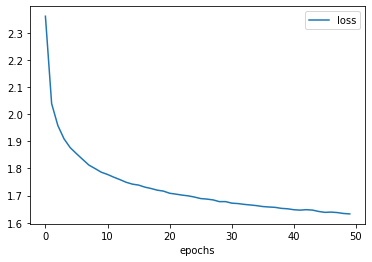

In [91]:
# Your plot code here
model_rnn = MyRNN()
model_rnn.to(device)

epochs = 50

train_model(model_rnn, epochs)

In [102]:
def generate_text(char_rnn, tokens = tokens, seed_phrase = 'darling, ', 
                    max_length = 100, temperature = 1., flag = False):
  
    x_sequence = torch.Tensor([np.array([token_to_idx[token] for token in seed_phrase.lower()])]).to(device)
    hid_state = char_rnn.initial_state(batch_size = 1)

    if flag: hid_state = tuple([each.data for each in hid_state])
    
    #start generating
    for _ in range(max_length - len(seed_phrase)):
        out, hid_state = char_rnn(torch.stack([x_sequence[:, -1].long()]), hid_state)
        preds =  F.softmax(out / temperature, dim = -1).cpu().data.numpy().squeeze()
        next_ix_ = np.random.choice(len(tokens), p = preds)
        next_ix = torch.LongTensor([[next_ix_]])

        x_sequence = torch.cat([x_sequence, next_ix.to(device)], dim = 1)
    return ''.join([tokens[int(ix)] for ix in x_sequence.cpu().data.numpy()[0]])

In [105]:
model_rnn.eval()
print(generate_text(char_rnn = model_rnn,  max_length = 500, temperature = 1.))

darling, efter,.
  cammy?
  so are remedpst,
  evey megoase wells eyes art my my sins mothen manhshers hatery own breast, that with orn great,
  and inink thou gain,
  bur fanting to dront.

  xxxlains hhats words thbourhy my slincey wendan whour my love, and he deasing thuch all my latter, lijeing.
  thy o'picing trueg, now shall i sofeding partus of can if,n a myom, to?
  and they plearing wist nealt, are my deos'd how it track'd hinn thee, swees your is thy deshed hrecalsen doend by arl and, 


### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

Plot the loss function of the number of epochs. Does the final loss become better?

In [113]:
# Your beautiful code here
class MyLSTM (nn.Module):
    def __init__(self, n_tokens = len(tokens), hidden_dim = 256, emb_dim = 128,
                 n_layers = 1):
        super(MyLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.emb_dim = emb_dim
        self.n_layers = n_layers
        self.n_tokens = emb_dim
        
        self.embed = nn.Embedding(n_tokens, self.emb_dim)
        self.lstm = nn.LSTM(self.emb_dim, self.hidden_dim, batch_first =  True)
        self.hid_to_logits = nn.Linear(self.hidden_dim, n_tokens)
    
    def forward(self, x, hidden_state):
        out, hidden_state = self.lstm(self.embed(x), hidden_state)
        out = self.hid_to_logits(out)
      
        return out, hidden_state
    
    def initial_state(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device),
        weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device))
        return hidden


In [125]:
def train_model_lstm(model, epochs=800):
    torch.manual_seed(7)

    batch_size = 512

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    loss_history = list()

    model.train()

    for epoch in range(epochs):
        curr_loss = []
        hidden_state = model.initial_state(batch_size)

        for batch_ind in range(batch_size, x.shape[0], batch_size):

            x_batch, y_batch = get_batches(x, y, device, batch_size, batch_ind)

            hidden_state = tuple([each.data for each in hidden_state])

            optimizer.zero_grad()
        
            seq, hidden_state = model_lstm(x_batch, hidden_state)
            loss = criterion(seq[:, -1].contiguous(), y_batch.contiguous())  
            loss.backward()
            optimizer.step()

            curr_loss.append(loss.item())  


        loss_history.append(np.mean(curr_loss))
        
        if (epoch + 1) % 5 == 0:
            clear_output(True)
            print(f'Epoch {epoch}')
            print(f'Current loss {loss_history[-1]}')
            
            plt.plot(loss_history, label = 'loss')
            plt.xlabel("epochs")
            plt.legend()
            plt.show()

Epoch 49
Current loss 0.613425596555074


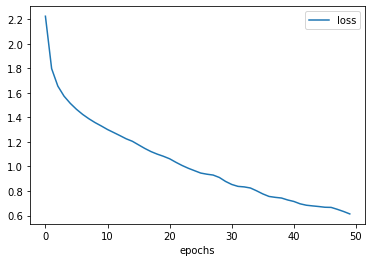

In [126]:
model_lstm = MyLSTM()
model_lstm.to(device)

epochs = 50

train_model_lstm(model_lstm, epochs)

Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [134]:
# Text generation with different temperature values here
model_lstm.eval()

for temperature in [0.1, 0.2, 0.5, 1.0, 2.0]:
  print("TEMPERATURE = ", temperature)
  poetry = generate_text(char_rnn = model_lstm, temperature = temperature,
                      max_length = 400, seed_phrase = "Darling, ")

  print('\t', poetry, '\n')

TEMPERATURE =  0.1
	 darling, are show
  hath love sometimes with thee are me proud,
  it for i praise that i have seen dids
  and see so dear from my mistress reeks.
  i love to my says be thy continual hast,
  excuse my verse is, being my desire,
  and that she is my self in sensers had allay'd,
  who lought thy contract of heart doth process.
    if it fearful seeming with thee thou be disgrace.
  what can seem lin 

TEMPERATURE =  0.2
	 darling, true time,
    those lines of thine, and i prove that i do change?
  why should my self, though i conscarer thought
  of thy love, and therefore in their heart
  of thy love, and therefore i love's eyes keep,
  and serving words, by in the same doth lies,
  and will is best, if it say that i do comment;
  look in the first in my saint to make thine,
  and in my sinful earth, so still to a 

TEMPERATURE =  0.5
	 darling, true thin,
  more blessed, seeing thou are right cast commitness spee:
    fast as thou are orn no far i come do near her,

При значении teperature = 0,2 - 0,5 тексты получились более красивые

### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [128]:
# Saving and loading code here
def save_net(net, name: str, opt):
    checkpoint = {'state_dict': net.state_dict(),
                  'opt_state_dict': opt.state_dict()}

    with open(name, 'wb') as f:
        torch.save(checkpoint, f)

In [133]:
optimizer = torch.optim.Adam(model_lstm.parameters(), lr=0.001)
save_net(model_lstm, "LSTM.net", optimizer)

checkpoint = torch.load("LSTM.net")
model_lstm.load_state_dict(checkpoint['state_dict'])
optimizer.load_state_dict(checkpoint['opt_state_dict'])
model_lstm.eval()
print(generate_text(char_rnn = model_lstm, temperature = 1.,
                      max_length = 450, seed_phrase = "Darling! "))

darling! blesson is'd prove
    that fair, swear it thoughts confoundly thin,
  summer's meturn than 'tis lived saw a fear roses dear'd,
  all men rankslating thy poor love in lost;
  lest is this worthes outworn, a doting sing:
    fanger sin walls, and love i for love?
  or, if it wersings to canstal like.
    but why rebeit and i delight'd thou shouldst assing,
  pitter in joyst thou know'st i think me wills of though rame:
  o! love, my mistr


### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a> 
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch`)